In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

from corr_lib import *

### Prepare data : sample stock returns from 2004 and from 2008

In [2]:
xl_SP500 = pd.ExcelFile("S&P_500_sectors_clean.xlsx")
df_SP500 = pd.read_excel(xl_SP500, sheet_name = 1)
date_SP500 = df_SP500['Date']
df_SP500 = df_SP500.set_index('Date')

START_DATE_OLD = datetime(2004, 1, 1)
END_DATE_OLD = datetime(2004, 6, 30)

df_SP500_old = df_SP500[df_SP500.index>=START_DATE_OLD].dropna(axis=1)
df_SP500_old = df_SP500_old[df_SP500_old.index<=END_DATE_OLD].dropna(axis=1)
df_SP500_old = df_SP500_old.drop('SPX Index', axis=1)

START_DATE_NEW = datetime(2008, 6, 30)
END_DATE_NEW = datetime(2008, 12, 31)

df_SP500_new = df_SP500[df_SP500.index>=START_DATE_NEW].dropna(axis=1)
df_SP500_new = df_SP500_new[df_SP500_new.index<=END_DATE_NEW].dropna(axis=1)
df_SP500_new = df_SP500_new.drop('SPX Index', axis=1)

data_old = np.array((np.log(df_SP500_old/df_SP500_old.shift(1))).dropna())
data_new = np.array((np.log(df_SP500_new/df_SP500_new.shift(1))).dropna())

### Gaussian transport

In [3]:
A = np.corrcoef(data_old.T)
B = np.corrcoef(data_new.T)

Kbar_gauss = frechet_barycenter_corr([A, B], force_corr=True, ord='wasserstein', verbose=False)

### Empirical measure transport

In [4]:
N = data_old.shape[1]
T_old = data_old.shape[0]
T_new = data_new.shape[0]

# point cloud
X = np.concatenate([data_old, data_new], axis=0)

### weights
# only put weights on the independant Gaussian
a = np.concatenate([np.ones(T_old), np.zeros(T_new)]) / T_old
# only put weights on the correlated Gaussian
b = np.concatenate([np.zeros(T_old), np.ones(T_new)]) / T_new

weights = np.stack([a, b], axis=1)

In [5]:
bar = empirical_frechet_barycenter(X, weights, eps_abs=5e-4, eps_rel=5e-4, verbose=False)
Kbar_emp = weighted_correlation(X, bar)

### Plot results

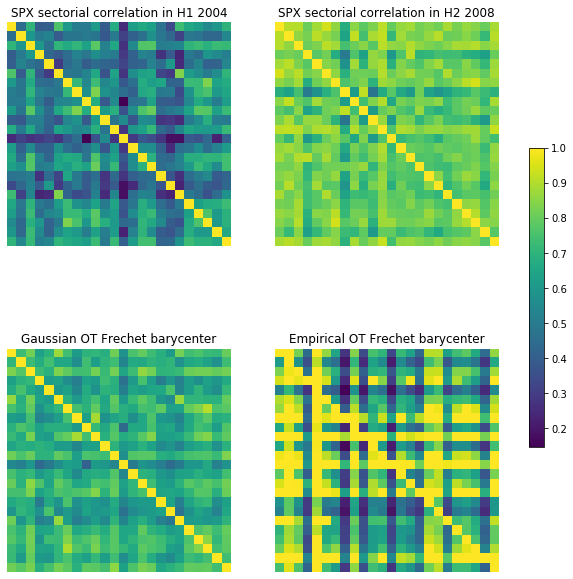

In [6]:
fig, axes = plt.subplots(figsize=(11, 11), nrows=2, ncols=2)
ax = axes[0, 0]
im = ax.imshow(A)
clim=im.properties()['clim']
ax.set_title('SPX sectorial correlation in H1 2004')
ax.axis('off')

ax = axes[0, 1]
ax.imshow(B, clim=clim)
ax.set_title('SPX sectorial correlation in H2 2008')
ax.axis('off')

ax = axes[1, 0]
ax.imshow(Kbar_gauss, clim=clim)
ax.set_title('Gaussian OT Frechet barycenter')
ax.axis('off')

ax = axes[1, 1]
ax.imshow(Kbar_emp, clim=clim)
ax.set_title('Empirical OT Frechet barycenter')
ax.axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)

plt.show()